# Reuters 딥러닝 모델

## 환경설정

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras.datasets import reuters

## 데이터 불러오기 및 검증데이터 분리

In [3]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


## 원핫 인코딩 실시

In [4]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
from tensorflow.keras.utils import to_categorical# label을 categorical 형태로 만드는 모듈

y_train_one_hot = to_categorical(train_labels) # GPT에 물어봤을때 num_class를 넣어줘야한다고 했었지만, 위에 46이이 나온 개념과 같아서
y_val_one_hot = to_categorical(val_labels) # 없어도 된다고 한다. dim 부분쪽에서 에러가 났었는지 오류가 지속적으로 떠서 헤맸었음
y_test_one_hot = to_categorical(test_labels)

## 모델학습

In [5]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
model = models.Sequential()
model.add(layers.Input(shape=(10000, )))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0

## 모델 컴파일 및 훈련 시작

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
from tensorflow.keras import callbacks
check_point_cb = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history = model.fit(x_train, y_train_one_hot, epochs=30, validation_data=(x_val, y_val_one_hot), callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/30
211/211 [==============================] - 3s 8ms/step - loss: 2.3385 - accuracy: 0.4774 - val_loss: 2.6887 - val_accuracy: 0.6790
Epoch 2/30
211/211 [==============================] - 1s 4ms/step - loss: 1.4882 - accuracy: 0.6513 - val_loss: 1.3860 - val_accuracy: 0.7240
Epoch 3/30
211/211 [==============================] - 1s 4ms/step - loss: 1.2547 - accuracy: 0.6966 - val_loss: 1.2504 - val_accuracy: 0.7440
Epoch 4/30
211/211 [==============================] - 1s 4ms/step - loss: 1.1076 - accuracy: 0.7308 - val_loss: 1.1722 - val_accuracy: 0.7538
Epoch 5/30
211/211 [==============================] - 1s 4ms/step - loss: 0.9703 - accuracy: 0.7610 - val_loss: 1.1541 - val_accuracy: 0.7729
Epoch 6/30
211/211 [==============================] - 1s 4ms/step - loss: 0.8882 - accuracy: 0.7795 - val_loss: 1.1198 - val_accuracy: 0.7814
Epoch 7/30
211/211 [==============================] - 1s 4ms/step - loss: 0.8192 - accuracy: 0.7985 - val_loss: 1.0971 - val_accuracy: 0.7832
Epoch 

## 학습데이터와 검증데이터 시각화

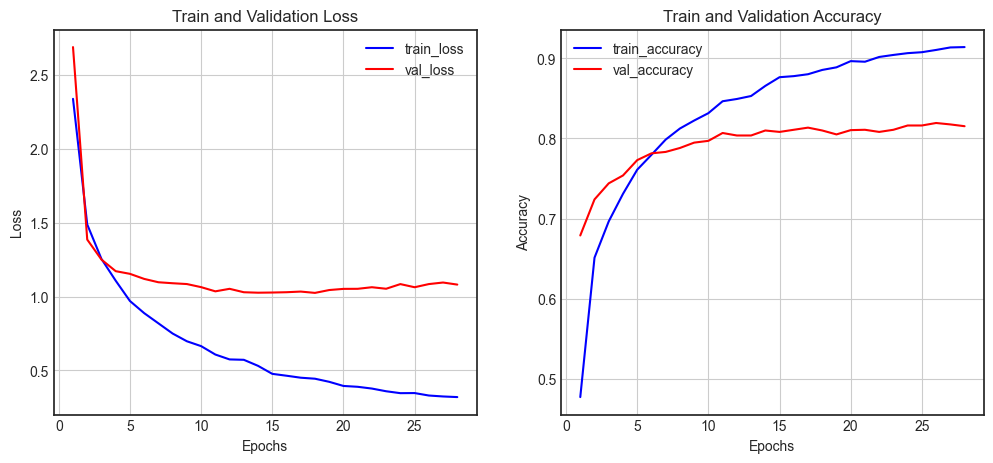

In [8]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 모델 평가

In [9]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot)
print(f"loss : {test_loss}")
print(f"acc : {test_acc}")

71/71 [==============================] - 0s 3ms/step - loss: 1.1292 - accuracy: 0.7930
loss : 1.1291946172714233
acc : 0.792965292930603


## 회고

배운 부분에서는 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 에서 loss를
sparse_categorical_crossentropy를 썼었다. 그래서 오류가 계속 났던 것이였다.
**원-핫 인코딩이 아닌 상태에서 sparse_categorical_crossentropy를 사용하고 있습니다. 따라서 모델을 컴파일할 때 categorical_crossentropy를 사용하거나, 레이블을 정수로 사용해 sparse_categorical_crossentropy를 계속 사용해야 합니다. 여기서는 categorical_crossentropy를 사용하도록 수정하겠습니다.**
라는 내용을 보고 사용했을 때 정상적인 진행이 되었었다.
이 부분에서 애를 먹었었기에 시간이 오래 걸렸다.

- **K**
    - 레이어층 구성 완벽 성공
    - check_point 와 ealry_stopping 부분 직접 코드 구현 실시 성공
- **P**
    - compile 부분의 지속적인 오류로 인한 시간 소모
- **T**
    - loss 관련 해서 열심히 검색을 해서 해결